# Generate PDF/A files from docTR output

These files have also a readable text layer on top of the image, which can be used to search in a document with any PDF-Viewer.

In [9]:
!pip3 install git+https://github.com/mindee/doctr.git
!pip3 install reportlab>=3.6.2
# optional if you want to merge multiple pdfs
!pip3 install PyPDF2==1.26.0

  Cloning https://github.com/mindee/doctr.git to /tmp/pip-req-build-bmhzcgbe
  Running command git clone -q https://github.com/mindee/doctr.git /tmp/pip-req-build-bmhzcgbe
  Resolved https://github.com/mindee/doctr.git to commit 7f396caff37a5bf482a139325fcc749e6bf86e24
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Created wheel for python-doctr: filename=python_doctr-0.6.0a0-py3-none-any.whl size=205179 sha256=4579c61d1d16cd50c420656b3642806cfa243d7fb2595005455f3d985fd3649b
  Stored in directory: /tmp/pip-ephem-wheel-cache-t0qsjce0/wheels/94/06/be/fd9b2fc506908bb3821b238760aad02b5b37dda25bc0acb0cb
Successfully built python-doctr
  Attempting uninstall: python-doctr
    Found existing installation: python-doctr 0.5.1a0
    Uninstalling python-doctr-0.5.1a0:
      Successfully uninstalled python-doctr-0.5.1a0


In [10]:
# Imports
import base64
import re
from tempfile import TemporaryDirectory
from math import atan, cos, sin
from typing import Dict, Optional, Tuple
from xml.etree import ElementTree as ET
from xml.etree.ElementTree import Element

import numpy as np
import PyPDF2
from PyPDF2 import PdfFileMerger
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image
from reportlab.lib.colors import black
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader
from reportlab.pdfgen.canvas import Canvas

## Define the hOCR (xml) parser
At the beginning, we have to define a HocrParser which is able to parse the exported XML-Tree/File.

[hOCR convention](https://github.com/kba/hocr-spec/blob/master/1.2/spec.md)

In [11]:
class HocrParser():

    def __init__(self):
        self.box_pattern = re.compile(r'bbox((\s+\d+){4})')
        self.baseline_pattern = re.compile(r'baseline((\s+[\d\.\-]+){2})')

    def _element_coordinates(self, element: Element) -> Dict:
        """
        Returns a tuple containing the coordinates of the bounding box around
        an element
        """
        out = out = {'x1': 0, 'y1': 0, 'x2': 0, 'y2': 0}
        if 'title' in element.attrib:
            matches = self.box_pattern.search(element.attrib['title'])
            if matches:
                coords = matches.group(1).split()
                out = {'x1': int(coords[0]), 'y1': int(
                    coords[1]), 'x2': int(coords[2]), 'y2': int(coords[3])}
        return out

    def _get_baseline(self, element: Element) -> Tuple[float, float]:
        """
        Returns a tuple containing the baseline slope and intercept.
        """
        if 'title' in element.attrib:
            matches = self.baseline_pattern.search(
                element.attrib['title']).group(1).split()
            if matches:
                return float(matches[0]), float(matches[1])
        return (0.0, 0.0)

    def _pt_from_pixel(self, pxl: Dict, dpi: int) -> Dict:
        """
        Returns the quantity in PDF units (pt) given quantity in pixels
        """
        pt = [(c / dpi * inch) for c in pxl.values()]
        return {'x1': pt[0], 'y1': pt[1], 'x2': pt[2], 'y2': pt[3]}

    def _get_element_text(self, element: Element) -> str:
        """
        Return the textual content of the element and its children
        """
        text = ''
        if element.text is not None:
            text += element.text
        for child in element:
            text += self._get_element_text(child)
        if element.tail is not None:
            text += element.tail
        return text

    def export_pdfa(self,
                    out_filename: str,
                    hocr: ET.ElementTree,
                    image: Optional[np.ndarray] = None,
                    fontname: str = "Times-Roman",
                    fontsize: int = 12,
                    invisible_text: bool = True,
                    add_spaces: bool = True,
                    dpi: int = 300):
        """
        Generates a PDF/A document from a hOCR document.
        """

        width, height = None, None
        # Get the image dimensions
        for div in hocr.findall(".//div[@class='ocr_page']"):
            coords = self._element_coordinates(div)
            pt_coords = self._pt_from_pixel(coords, dpi)
            width, height = pt_coords['x2'] - \
                pt_coords['x1'], pt_coords['y2'] - pt_coords['y1']
            # after catch break loop
            break
        if width is None or height is None:
            raise ValueError("Could not determine page size")

        pdf = Canvas(out_filename, pagesize=(width, height), pageCompression=1)

        span_elements = [element for element in hocr.iterfind(".//span")]
        for line in span_elements:
            if 'class' in line.attrib and line.attrib['class'] == 'ocr_line' and line is not None:
                # get information from xml
                pxl_line_coords = self._element_coordinates(line)
                line_box = self._pt_from_pixel(pxl_line_coords, dpi)

                # compute baseline
                slope, pxl_intercept = self._get_baseline(line)
                if abs(slope) < 0.005:
                    slope = 0.0
                angle = atan(slope)
                cos_a, sin_a = cos(angle), sin(angle)
                intercept = pxl_intercept / dpi * inch
                baseline_y2 = height - (line_box['y2'] + intercept)

                # configure options
                text = pdf.beginText()
                text.setFont(fontname, fontsize)
                pdf.setFillColor(black)
                if invisible_text:
                    text.setTextRenderMode(3)  # invisible text

                # transform overlayed text
                text.setTextTransform(
                    cos_a, -sin_a, sin_a, cos_a, line_box['x1'], baseline_y2)

                elements = line.findall(".//span[@class='ocrx_word']")
                for elem in elements:
                    elemtxt = self._get_element_text(elem).strip()
                    # replace unsupported characters
                    elemtxt = elemtxt.translate(str.maketrans(
                        {'ﬀ': 'ff', 'ﬃ': 'f‌f‌i', 'ﬄ': 'f‌f‌l', 'ﬁ': 'fi', 'ﬂ': 'fl'}))
                    if not elemtxt:
                        continue

                    # compute string width
                    pxl_coords = self._element_coordinates(elem)
                    box = self._pt_from_pixel(pxl_coords, dpi)
                    if add_spaces:
                        elemtxt += ' '
                        box_width = box['x2'] + pdf.stringWidth(elemtxt, fontname, fontsize) - box['x1']
                    else:
                        box_width = box['x2'] - box['x1']
                    font_width = pdf.stringWidth(elemtxt, fontname, fontsize)

                    # Adjust relative position of cursor
                    cursor = text.getStartOfLine()
                    dx = box['x1'] - cursor[0]
                    dy = baseline_y2 - cursor[1]
                    text.moveCursor(dx, dy)

                    # suppress text if it is 0 units wide
                    if font_width > 0:
                        text.setHorizScale(100 * box_width / font_width)
                        text.textOut(elemtxt)
                pdf.drawText(text)

        # overlay image if provided
        if image is not None:
            pdf.drawImage(ImageReader(Image.fromarray(image)),
                          0, 0, width=width, height=height)
        pdf.save()

## OCR the files and show the results

Now we are ready to start the OCR process and show the results.

--2022-03-29 12:10:44--  https://www.allianzdirect.de/dam/documents/home/Versicherungsbedingungen-08-2021.pdf
Resolving www.allianzdirect.de (www.allianzdirect.de)... 18.66.139.21, 18.66.139.56, 18.66.139.114, ...
Connecting to www.allianzdirect.de (www.allianzdirect.de)|18.66.139.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913635 (892K) [application/pdf]
Saving to: ‘Versicherungsbedingungen-08-2021.pdf’

Versicherungsbeding 100%[===================>] 892,22K  4,84MB/s    in 0,2s    

2022-03-29 12:10:44 (4,84 MB/s) - ‘Versicherungsbedingungen-08-2021.pdf’ saved [913635/913635]



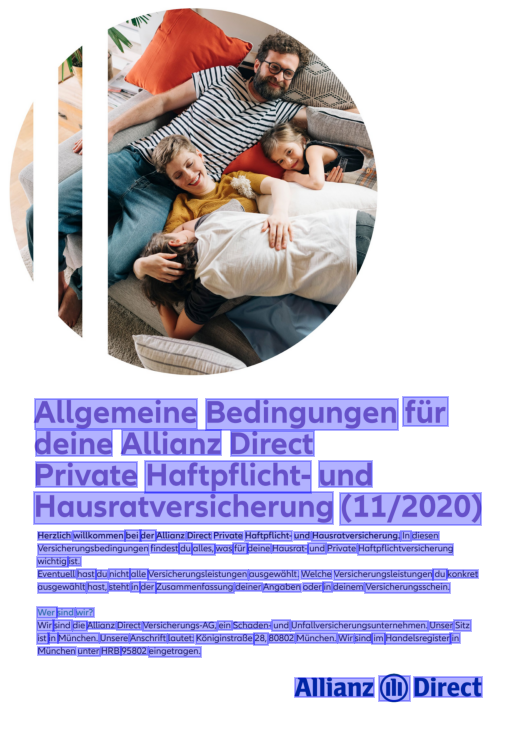

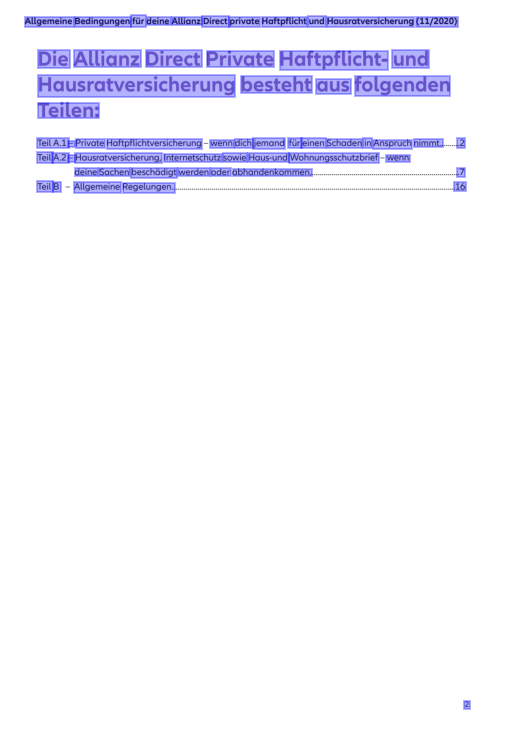

In [12]:
# Download a sample
!wget https://www.allianzdirect.de/dam/documents/home/Versicherungsbedingungen-08-2021.pdf
# Read the file
docs = DocumentFile.from_pdf("Versicherungsbedingungen-08-2021.pdf")
model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True)
# we will grab only the first two pages from the pdf for demonstration
result = model(docs[:2])
result.show(docs)

## Export as PDF/A 
In this section we will export our documents as PDF/A files.

We show 3 possible options for this.

### All as single PDF/A file
All files will be saved as single file.

In [13]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# init the above parser
parser = HocrParser()

# iterate through the xml outputs and images and export to pdf/a
# the image is optional else you can set invisible_text=False and the text will be printed on a blank page
for i, (xml, img) in enumerate(zip(xml_outputs, docs)):
    xml_element_tree = xml[1]
    parser.export_pdfa(f'{i}.pdf', hocr=xml_element_tree, image=img)

### All merged into one PDF/A file
All PDF/A files will be merged into one PDF/A file.

In [14]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# init the above parser
parser = HocrParser()

# you can also merge multiple pdfs into one

merger = PdfFileMerger()
for i, (xml, img) in enumerate(zip(xml_outputs, docs)):
    xml_element_tree = xml[1]
    with TemporaryDirectory() as tmpdir:
        parser.export_pdfa(f'{tmpdir}/{i}.pdf', hocr=xml_element_tree, image=img)
        merger.append(f'{tmpdir}/{i}.pdf')
merger.write(f'docTR-PDF.pdf')

### All as base64 encoded PDF/A files
All PDF/A files will be saved as base64 strings in a list.

In [15]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# init the above parser
parser = HocrParser()

# or encode the pdfs into base64 (Rest API usage)

base64_encoded_pdfs = list()
for i, (xml, img) in enumerate(zip(xml_outputs, docs)):
    xml_element_tree = xml[1]
    with TemporaryDirectory() as tmpdir:
        parser.export_pdfa(f'{tmpdir}/{i}.pdf',
                           hocr=xml_element_tree, image=img)
        with open(f'{tmpdir}/{i}.pdf', 'rb') as f:
            base64_encoded_pdfs.append(base64.b64encode(f.read()))
print(f'{len(base64_encoded_pdfs)} pdfs encoded')

2 pdfs encoded


## How can I use a PDF/A?
You can open the saved pdf's with any PDF-Viewer and type some words you are searching for in the document.

Matches will be highlighted in the text layer.

Or you use Python to search, for example words in the text layer.

In [16]:
# search specific words in the pdf and print all matches
pattern = "Allianz"
file_name = "docTR-PDF.pdf"

reader = PyPDF2.PdfFileReader(file_name)
num_pages = reader.getNumPages()

for i in range(0, num_pages):
    page = reader.getPage(i)
    text = page.extractText()
    
    for match in re.finditer(pattern, text):
        print(f'Page no: {i} | Match: {match}')

Page no: 0 | Match: <re.Match object; span=(33, 40), match='Allianz'>
Page no: 0 | Match: <re.Match object; span=(131, 138), match='Allianz'>
Page no: 0 | Match: <re.Match object; span=(516, 523), match='Allianz'>
Page no: 0 | Match: <re.Match object; span=(778, 785), match='Allianz'>
Page no: 1 | Match: <re.Match object; span=(33, 40), match='Allianz'>
Page no: 1 | Match: <re.Match object; span=(106, 113), match='Allianz'>


## To go further
[Wikipedia PDF/A](https://en.wikipedia.org/wiki/PDF/A)

[Difference between PDF/A and PDF](https://askanydifference.com/difference-between-pdf-a-and-pdf/)

### Happy Coding :)